<a href="https://colab.research.google.com/github/Mas4oll/Topicos_IA/blob/main/Reconocmiento_de_Piezas_de_Manufactura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(22, 80, 80, 1)
Entrada entrenamiento= [[[[0.83529412]
   [0.83529412]
   [0.83529412]
   ...
   [0.89411765]
   [0.89803922]
   [0.89803922]]

  [[0.83137255]
   [0.81960784]
   [0.83921569]
   ...
   [0.89019608]
   [0.89411765]
   [0.89411765]]

  [[0.82352941]
   [0.82745098]
   [0.82745098]
   ...
   [0.88627451]
   [0.90196078]
   [0.89019608]]

  ...

  [[0.76078431]
   [0.75686275]
   [0.77254902]
   ...
   [0.90588235]
   [0.89019608]
   [0.88627451]]

  [[0.77254902]
   [0.76470588]
   [0.75686275]
   ...
   [0.89803922]
   [0.89019608]
   [0.87843137]]

  [[0.76470588]
   [0.77254902]
   [0.78823529]
   ...
   [0.89411765]
   [0.91764706]
   [0.91764706]]]


 [[[0.91372549]
   [0.90980392]
   [0.90980392]
   ...
   [0.93333333]
   [0.94509804]
   [0.94117647]]

  [[0.90588235]
   [0.90588235]
   [0.90980392]
   ...
   [0.93333333]
   [0.94509804]
   [0.94117647]]

  [[0.90196078]
   [0.89019608]
   [0.89411765]
   ...
   [0.9372549 ]
   [0.94117647]
   [0.9372549 ]]

  ...



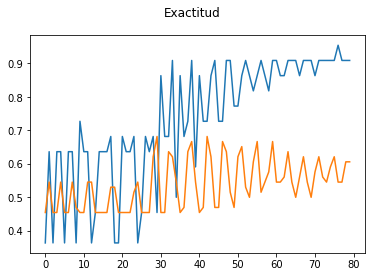

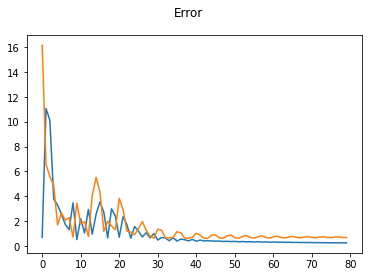

In [35]:
#Clase de Topicos Avanzados de Inteligencia Artificial de la Universidad Veracruzana
#Uso de vision artificial
#Uso de procesamiento de imagenes con CV2 y Redes Neuronales con Tensorflow
#Proyecto Final a 12-12-21 - Reconocmiento de Piezas de Manufactura (Alfa) por JM

#from google.colab import files
#uploaded = files.upload()
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.python.keras.layers.pooling import MaxPooling2D



class Pieza(object):
    def __init__(self, dato, estado, x, y, z):
        self.dato = dato
        self.pos = [x,y,z]
        self.dato = estado
        self.id = []

    def crear_id(self, num_piezas): #Se debera cambiar cuando se identifiquen el numero de piezas posteriormente
        for i in range(num_piezas):
          r = random.randint(1, 100000)
          if r not in self.id:
            self.id.append(r)
        print("{} id(s) vinculados a piezas".format(len(self.id)))
        return self.id

    def identifica_pieza(self, estado):
        for i in range(len(self.id)):
          print("Pieza {} identificada, estado: {}".format(self.id[i], estado))
        return


class Robot(object):
    def __init__(self, id, dato, estado, x, y, z, vel, acel):
        super(Robot, self).__init__()
        self.id = id
        self.dato = dato
        self.pos = [x,y,z]
        self.estado = estado
        self.vel = 0
        self.acel = 0

    def moverse_recursivo(self, xdestino, ydestino, zdestino):
        if self.pos[0] == xdestino and ydestino == self.pos[1] and zdestino == self.pos[2]:
            print("Piezas colocadas")
            return
        if self.pos[0] < xdestino:
            self.pos[0] +=1
        elif self.pos[0] > xdestino:
            self.pos[0] -=1
        if self.pos[1] < ydestino:
            self.pos[1] +=1
        elif self.pos[1] > ydestino:
            self.pos[1] -=1
        if self.pos[2] < zdestino:
            self.pos[2] +=1
        elif self.pos[2] > zdestino:
            self.pos[2] -=1
        print(self.pos)
        self.moverse_recursivo(xdestino, ydestino, zdestino)
        return


class Intruso(object):
    def __init__(self, x, y, z):
        super(Intruso, self).__init__()
        self.estado = False
        self.pos = [x,y,z]

    def identifica_intruso(self, estado):
      self.estado = estado
      if estado == True:
        print("Intruso detectado en: {}".format(self.pos))
        print("Paro de emergencia activado")

class Maquina(object):
  def __init__(self, funcion, pbuenas, pmalas):
    super(Maquina, self).__init__()
    self.estado = []
    self.pbuenas = []
    self.pmalas = []

  def genera_reporte(self, ids, des_std, des_mean):
    for b in self.pbuenas:
      self.estado.append("buena")
    for m in self.pmalas: 
      self.estado.append("mala")
    df = pd.DataFrame({
        'id': [ids],
        'Desviacion Media': [des_mean],
        'Calidad': [self.estado],
        'Desviacion Estandar': [des_std]})
    print("Reporte:", df)

    return


'''
Lectura de imagen
'''
def process_get_image(files):
    img = cv2.imread(files)
    # Imprime mensaje de error si la lectura es null
    if img is None:
        print('No se pudo leer la imagen')
    scale_percent = 10
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    imgcol = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img, imgcol, img_gray, img_hsv



'''
Deteccion automatica de bordes con Canny
'''
def process_canny(original, kernel = np.ones((3,3), np.uint8), sigma=1): #Default = 0.33 sube o baja el umbral
    gauss = cv2.GaussianBlur(original, (3,3),0)
    v = np.median(gauss)
    bajo = int(max(0, (1.0 - sigma) * v))
    alto = int(min(255, (1.0 + sigma) * v)) 
    imcanny = cv2.Canny(gauss, bajo, alto)
    bordes_gordos = cv2.dilate(imcanny, kernel)
    contornos, _ = cv2.findContours(bordes_gordos,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    objeto = bordes_gordos.copy()
    maxcnt = max(contornos, key=cv2.contourArea)
    im2 = cv2.drawContours(objeto, [maxcnt], -1,255, thickness=-1)
    hull = cv2.convexHull(maxcnt)
    puntos_convex = hull[:,0,:]
    imgzeros = np.zeros(imcanny.shape)
    mascara_convex = cv2.fillConvexPoly(imgzeros, puntos_convex, 1)
    return im2, mascara_convex, puntos_convex

'''
Homografia
'''
# def get_homography(cont):
#     epsilon = 0.01 * cv2.arcLength(cont,True)
#     approx = cv2.approxPolyDP(cont, epsilon, True)
#     xdp = approx[:,0,0]
#     ydp = approx[:,0,1]
#     box = approx[:,0]
#     plt.figure()
#     plt.suptitle("Homografia")
#     plt.imshow(mascara_convex)
#     plt.scatter(xdp[2],ydp[2], color="red")
#     approx.shape
#     pts_src = np.array([box[0],box[3],box[1],box[2]])
#     h = 4800
#     w = 1500
#     pts_dst = np.array([[0,0],[w,0],[0,h],[w,h]])
#     mat, _ = cv2.findHomography(pts_src, pts_dst)
#     img2 = cv2.warpPerspective(img, mat, (w,h))
#     plt.imshow(img2, cmap="gray")
#     return 

'''
Generacion y deteccion de numero de elementos y etiquetas
'''
def get_num(dataset_buenas, dataset_malas):
    dataset_buenas =  np.array(dataset_buenas)
    dataset_malas = np.array(dataset_malas)
    total_muestras = len(dataset_buenas)+len(dataset_malas)
    num_buenas = len(dataset_buenas)
    num_malas = len(dataset_malas)
    return total_muestras, num_buenas, num_malas

'''
Generacion y comparacion por histogramas
'''
def get_histogram(img, img_gray, mask):
    plt.figure("Histogramas")
    plt.hist(img_gray.ravel(),256,[0,256]);
    plt.suptitle("Histogramas")
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    mask = np.uint8(mask)
    hist_mask = cv2.calcHist([img_gray],[0],mask,[256],[0,256])
    plt.figure()
    plt.plot(hist_mask)
    plt.suptitle("Histograma con mascara")
    masked_img = cv2.bitwise_and(img_gray,img_gray,mask = mask)
    equ = cv2.equalizeHist(masked_img)
    res = np.hstack((masked_img,equ))
    plt.figure()
    plt.suptitle("Histograma Ecualizado con mascara comparacion")
    plt.imshow(res)
    #Otra manera de ecualizar histograma por limitacion de contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(masked_img)
    cl2 = np.hstack((masked_img, cl1))
    plt.figure()
    plt.suptitle("Histograma CLAHE con mascara comparacion")
    plt.imshow(cl2)
    return masked_img, hist_mask, equ, cl1



'''
Obteniendo las distancias en los histogramas
'''
def chi_square(h1,h2):
    return sum(np.divide(np.power(h1-h2,2),h1,out=np.zeros_like(h1), where=h1!=0))
def correlacion(h1,h2):
    promh1 = np.mean(h1)
    promh2 = np.mean(h2)
    x1 = h1-promh1
    x2 = h2-promh2
    fact1 = sum((x1)*(x2))
    fact2 = np.sqrt(abs(sum(x1*x1) * sum(x2*x2)))
    return fact1/fact2
def intersection(h1,h2):
    return sum(np.minimum(h1,h2))
def Bhattacharyya(h1,h2):
    N=len(h1)
    N2=N*N
    promh1 = np.mean(h1)
    promh2 = np.mean(h2)
    sumatoria=sum(np.sqrt(abs(h1*h2)))
    return(np.sqrt(abs(1-(1/np.sqrt(abs(promh1*promh2*N2)))*sumatoria))) #formula opencv

'''
Deteccion automatica de esquinas con Harris
'''
def process_harry(img_filtrada):
    img_gray = np.float32(img_filtrada)
    dst = cv2.cornerHarris(img_gray, 6, 3, 0.06) #Ajusta el tamanio, el kernel, precision < numero = mas preciso
    dst = cv2.dilate(dst, None)
    img[dst > 0.01 * dst.max()]=[0,255,0]
    plt.figure()
    plt.suptitle("Esquinas con Harris")
    plt.imshow(img)
    return dst

'''
Deteccion automatica de puntos
'''
def get_features(puntos):
    puntosx = puntos.flatten()[::2]
    puntosy = puntos.flatten()[1::2]

    centroidex = puntosx.mean()
    centroidey = puntosy.mean()

    distances = []

    for p in pnt:
        distances.append(np.linalg.norm([centroidex, centroidey] -p))
    distances = np.array(distances)
    return distances.mean(), distances.std()


'''
Grafica la extraccion de caracteristicas
'''
def plot_differences(dataset_buenas, dataset_malas):
    dataset_buenas =  np.array(dataset_buenas)
    dataset_malas = np.array(dataset_malas)
    puntosxb = dataset_buenas.flatten()[::2]
    puntosyb = dataset_buenas.flatten()[1::2]
    puntosxm = dataset_malas.flatten()[::2]
    puntosym = dataset_malas.flatten()[1::2]
    plt.figure()
    plt.suptitle("Caracteristicas")
    plt.scatter(puntosxb, puntosyb, color="green")
    plt.scatter(puntosxm, puntosym, color="red")
    return 


'''
Redes Neuronales
'''
dir = ""
categorias = ["buenas", "malas"] #0 = buenas y 1 = malas
datos_entrenamiento = []

def get_training_data():
  for c in categorias: 
    path = os.path.join(dir, c)
    cat_num = categorias.index(c)
    for img in os.listdir(path):
      img_samples = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      img_size = 80
      img_samples = cv2.resize(img_samples, (img_size, img_size))
      datos_entrenamiento.append([img_samples, cat_num])
  # print(len(datos_entrenamiento))
  random.shuffle(datos_entrenamiento)
  # for sample in datos_entrenamiento:
  #   print(sample[1])
  x = []
  y = []
  for features, etiquetas in datos_entrenamiento:
    x.append(features)
    y.append(etiquetas)
  x = np.array(x).reshape(-1, img_size, img_size, 1) #El ultimo numero indica escala de grises
  y = np.array(y)
  x = x/255
  return x, y


def think(x, y):
  X_train = x[:22]
  print(X_train.shape)
  print("Entrada entrenamiento=",X_train)
  y_train = y[:22]
  print(y_train.shape)
  print("Salida entrenamiento=",y_train)
  X_test = x[22:]
  print(X_test.shape)
  print("Entrada prueba=",X_test)
  y_test = y[22:]
  print(y_test.shape)
  print("Salida prueba=",y_test)
  modelo = Sequential() #input_shape = (302,403, 1)
  modelo.add(Dense(80, input_shape=x.shape[1:], activation="relu")) #88 muestras en total
  modelo.add(Flatten())
  modelo.add(Dense(100, activation="relu"))
  modelo.add(Dense(100, activation="relu"))
  modelo.add(Dense(1, activation="sigmoid"))
  modelo.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
  modelo.summary()
  # history = modelo.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), epochs=500)
  history = modelo.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), epochs=80)  
  datos = pd.DataFrame(history.history)
  plt.figure()
  plt.suptitle("Exactitud")
  datos.accuracy.plot()
  datos.val_accuracy.plot()
  plt.figure()
  plt.suptitle("Error")
  datos.loss.plot()
  datos.val_loss.plot()
  resultados=modelo.predict(np.array([x[5],]))
  #resultados[10]
  #X_test[10]
  y_test
  resultados
  return 


# '''
# Simulacion de planta
# '''
# keycap = Pieza("Maquina1", "Bueno", 50, 38, 27)
# mano = Intruso(40, 50, 23)
# robot_demo = Robot("R01", "clasificador", "Bueno", 50, 38, 27, 2, 0.5)



# '''
# Proceso para buenas
# '''
# buenas = []
# dataset_buenas=[]
# for files in glob.glob('buenas/*.*'):
#     img, imgcol, img_gray, img_hsv = process_get_image(files)
#     buenas.append(img_gray)
#     # red_keycap = get_color(imgcol)
#     cont, mask, pnt = process_canny(img_gray)
#     masked_img, hist_mask, equ, cl1 = get_histogram(img, img_gray, mask)
#     dst2 = process_harry(mask)
#     keycap.identifica_pieza("Buena")
#     des_mean, des_std = get_features(pnt)
#     dataset_buenas.append(list(get_features(pnt)))
# '''
# Proceso para malas
# '''
# malas =[]
# dataset_malas=[]
# for files in glob.glob('malas/*.*'):
#     img, imgcol, img_gray, img_hsv = process_get_image(files)
#     malas.append(img_gray)
#     # red_keycap = get_color(imgcol)
#     cont, mask, pnt = process_canny(img_gray)
#     masked_img, hist_mask, equ, cl1 = get_histogram(img, img_gray, mask)
#     dst2 = process_harry(mask)
#     keycap.identifica_pieza("Mala")
#     des_mean, des_std = get_features(pnt)
#     dataset_malas.append(list(get_features(pnt)))

# '''
# Proceso de categorias de muestras
# '''
# plot_differences(dataset_buenas, dataset_malas)
# total_muestras, num_buenas, num_malas = get_num(dataset_buenas, dataset_malas)
# print("Total de muestras:", total_muestras)
# ids = keycap.crear_id(total_muestras)
# robot_demo.moverse_recursivo(100, 24, 78)
# mano.identifica_intruso(False)
x, y = get_training_data()
think(x, y)

# '''
# Generamos el estado de la maquina
# '''
# des_mean, des_std = get_features(pnt)
# M1 = Maquina("keycaps", num_buenas, num_malas)
# M1.genera_reporte(ids, des_std, des_mean)


if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()